## Multi-mode data

Finally we repeat the modelling part of this notebook using in this case multiple modes (fundamental, 1st, and 2nd).

In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
# import pylops

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

from surfacewaves import *
from dispersionspectra import *
from inversion import *

In [2]:
def showDp2ShotGather(cpr, dshift, x, t, i=0):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    color = ['k', 'r', 'g']

    for imode in range(3):
        axs[0].plot(np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), color[imode], lw=4, label=f'Mode{imode}')
    axs[0].legend()
    axs[0].set_xlabel('f [hz]')
    axs[0].set_ylabel('v [km/s]')
    axs[0].set_title('Rayleigh-wave fundamental model dispersion curve');

    axs[1].imshow(dshift.T, cmap='coolwarm', extent=[x[0], x[-1], t[-1], t[0]], vmin=-.15, vmax=.15)
    axs[1].axis('tight')
    axs[1].set_xlabel('Offset [m]')
    axs[1].set_ylabel('Time [s]')
    axs[1].set_title('Shot gather')

    fig.tight_layout()
    # fig.savefig(f'figs/{i:03d}.png', dpi=300)

In [3]:
# Define model as:
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
thick = np.array([0.01, 0.02, 0.03, 0.01])
vs = np.array([0.2, 0.4, 0.6, 0.8])
true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

# Frequency axis
fdisp = np.linspace(3, 20, 301)

# Periods (must be sorted starting with low periods)
period = np.flipud(1/fdisp)

# Rayleigh-wave fundamental model dispersion curve 
pd = PhaseDispersion(*true_model.T)
cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]


## Synthetic seismogram

Next, we will be using the dispersion relation to create a surface-wave only seismic shot gather. This is of course a highly simplified version of what you would obtain by using the full elastic wave equation; nevertheless, it serves as a good basis to test algorithms used to create dispersion spectra as it does not contain any interference from other modes and other types of waves (e.g., direct arrival, reflections..).

The modelling is performed in the frequency domain as follows:

$$
d(f,x) = s(f) e^{j 2 \pi f x/v(f)}
$$

where $s(f)$ is the frequency spectrum of the source wavelet.

In [4]:
# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

t, x = np.arange(nt)*dt, np.arange(nx)*dx

# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

# Data
dshifts, fs, vfs = [], [], []
for imode in range(3):
    dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                       np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
    dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
    fs.append(f_)
    vfs.append(vf_)
dshift = np.concatenate(dshifts).sum(0)


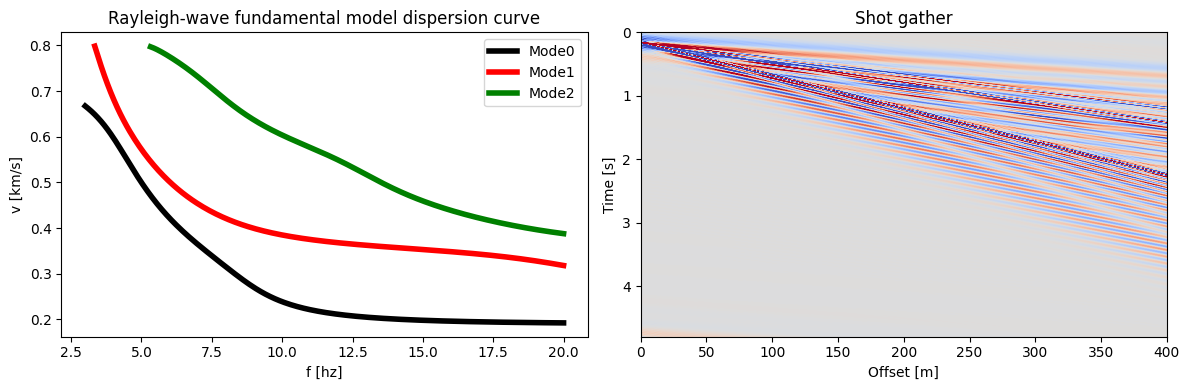

In [5]:
showDp2ShotGather(cpr, dshift, x, t)

In [6]:
import ccfj
import scipy
from Dispersion.dispersion import get_dispersion

dc = 1.
cmin, cmax = 100., 800.
fmin, fmax = fdisp.min(), fdisp.max()

f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)


nx, nt = dshift.shape
x = np.arange(nx)*dx
f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
c = np.linspace(cmin, cmax, 1000)

out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)

(201, 300) (300,) 600 201
Frequency resolution up to 20.00 Hz: 95 bins
Phase velocity resolution up to 800.00 m/s: 700 bins


Text(0.5, 1.0, 'F-J')

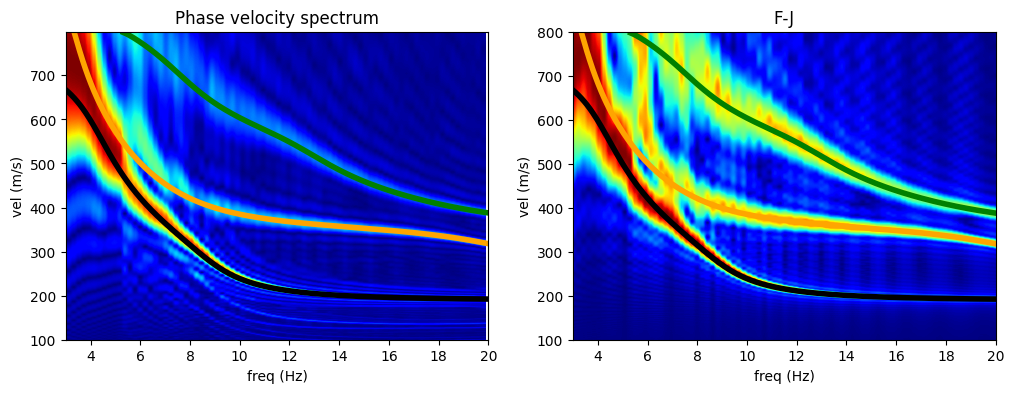

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
color = ['k', 'orange', 'g']

axs[0].imshow(img, aspect='auto', cmap='jet',
           extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')
axs[1].imshow(out, aspect='auto', cmap='jet',
           extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

for imode in range(3):
    axs[0].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                color[imode], lw=4, label=f'Mode{imode}')
    axs[1].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                color[imode], lw=4, label=f'Mode{imode}')

axs[0].set_xlim(fmin, fmax)
axs[1].set_xlim(fmin, fmax)

axs[0].set_xlabel('freq (Hz)')
axs[0].set_ylabel('vel (m/s)')
axs[0].set_title('Phase velocity spectrum')
axs[1].set_xlabel('freq (Hz)')
axs[1].set_ylabel('vel (m/s)')
axs[1].set_title('F-J')

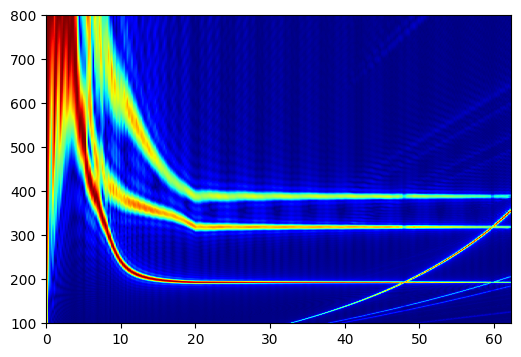

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(out, aspect='auto', cmap='jet',
           extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')


(3.0, 20.0)

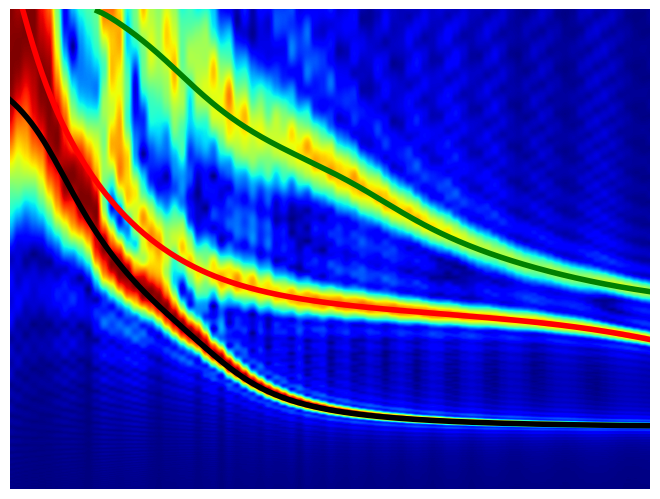

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(out, aspect='auto', cmap='jet',
          extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

for imode in range(3):
    ax.plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                color[imode], lw=4, label=f'Mode{imode}')

ax.margins(0)
ax.set_xlim(fmin, fmax)
# fig.savefig(f'{save_path/file.stem}.png', bbox_inches='tight', pad_inches=0, dpi=40)
# plt.close()

(3.0, 20.0)

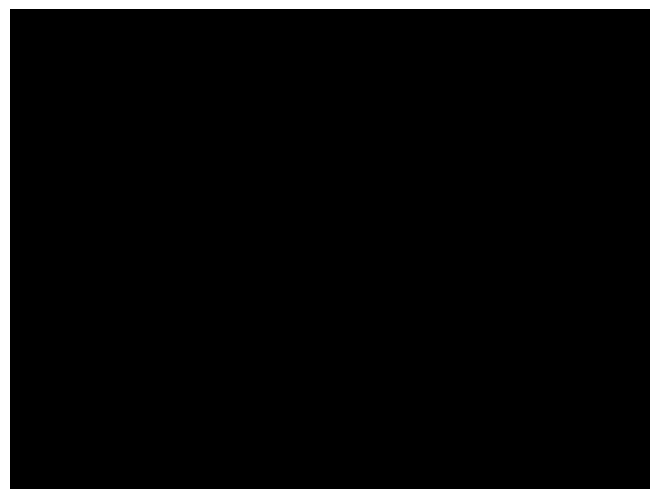

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(np.zeros_like(out), aspect='auto', cmap='gray',
          extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
ax.margins(0)
ax.set_xlim(fmin, fmax)

In [11]:
from Dispersion.utils import gen_model1
from evodcinv import EarthModel, Layer, Curve

# # Define model as:
# # thickness, Vp, Vs, density
# # km, km/s, km/s, g/cm3
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
# true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

# # Frequency axis
# fdisp = np.linspace(3, 20, 301)

# # Periods (must be sorted starting with low periods)
# period = np.flipud(1/fdisp)

# # Rayleigh-wave fundamental model dispersion curve 
# pd = PhaseDispersion(*true_model.T)
# cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]



# Initialize model
model = EarthModel()

# #                   d [km]     vs [km/s]
# #                min    max    min  max
model.add(Layer([0.008, 0.03], [0.1, 0.3]))  # Layer 1
model.add(Layer([0.005, 0.05], [0.2, 0.6]))  # Layer 1
model.add(Layer([0.005, 0.05], [0.4, 0.8]))  # Layer 1
model.add(Layer([0.005, 0.05], [0.4, 1.0]))  # Layer 1

# Configure model
maxiter = 500
model.configure(
    optimizer      = "cmaes",       # Evolutionary algorithm,'cmaes','cpso','de','na','pso','vdcma'
    misfit          = "rmse",        # Misfit function type, 'rmse','norm1','norm2'
    optimizer_args = {
                "popsize": 10,      # Population size
                "maxiter": maxiter,    # Number of iterations
                "workers": -1,      # Number of cores
                "seed"   : 11,
            },
)

mode = 1
curves = [Curve(cpr[mode][0], cpr[mode][1], mode, "rayleigh", "phase", weight=1.0, uncertainties=None)]

# Run inversion
res = model.invert(curves)
print(res)



pd = PhaseDispersion(*res.model.T)
cpr_1 = pd(cpr[mode][0], mode=mode, wave="rayleigh")


ModuleNotFoundError: No module named 'Dispersion.utils'

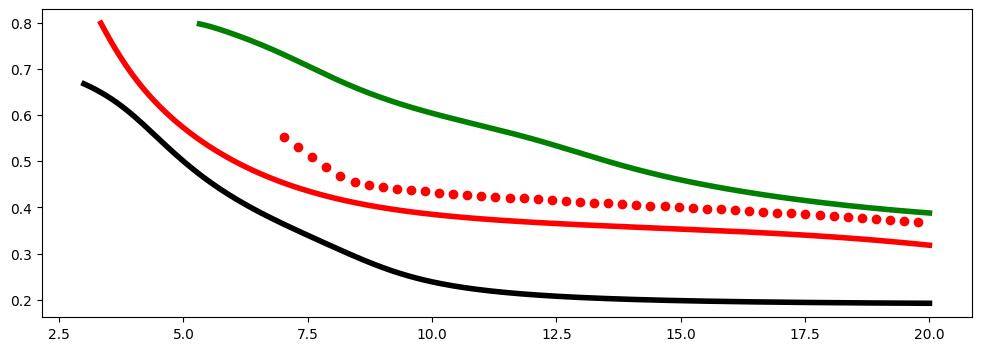

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))

for imode in range(3):
    axs.plot(np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), color[imode], lw=4, label=f'Mode{imode}')

axs.plot(np.flipud(1/cpr_1[0])[::5], np.flipud(cpr_1[1])[::5], 'ro', lw=1, label=f'Mode0')

## Inversion

Finally we write a simple deterministic inversion algorithm to estimate thicknesses and shear wave velocities $(\Delta z, v_s)$ from the dispersion curve of the fundamental mode. In this case, we assume a known relationship between $v_p$ and $v_s$ and constant density $rho$. We also assume that the number of layers is known a priori.

Here, we simply leverage scipy's `scipy.optimize.minimize` method. From a user perspective, we are simply required to write a function that takes all the inputs (here all thicknesses and shear wave velocities for the different layers) and returns a measure of distance (or misfit) between the true and predicted dispersion curve.

In [ ]:
# Exact solution
nlayers = 4
thick0 = true_model[:, 0]
vs0 = true_model[:, 2]
mode = 1


x0 = np.hstack([thick0, vs0])
# vdisp = np.flipud(cpr[mode][1]) # flip it back to show it as function of f instead of period
vdisp = cpr[mode][1]
fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp),mode=mode)

1.828900129995257

In [ ]:
# Initial solution
nlayers = 4
thick0 = np.array([0.01, 0.02, 0.02, 0.01])
vs0 = np.array([0.2, 0.41, 0.61, 0.8])
x0 = np.hstack([thick0, vs0])


fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp),mode=mode)

1.855521958532884

In [ ]:
from functools import partial
from scipy.optimize import minimize, Bounds

# Inversion
nlayers = 4
thick0 = np.array([0.01, 0.02, 0.03, 0.01])
vs0 = np.array([0.2, 0.41, 0.61, 0.8])
x0 = np.hstack([thick0, vs0])

bd = Bounds(lb=np.zeros(nlayers*2), ub=np.inf * np.ones(nlayers*2), keep_feasible=False)
nl = minimize(fun, x0.ravel(), 
              args=(nlayers, period, np.flipud(vdisp),mode,0.005), 
              bounds=bd, method='Nelder-Mead', options=dict(maxiter=1000))
thickest = nl.x[:nlayers]
vsest = nl.x[nlayers:]

print('Thickness', thick, thick0, thickest)
print('VS', vs, vs0, vsest)

ValueError: operands could not be broadcast together with shapes (289,) (301,) 

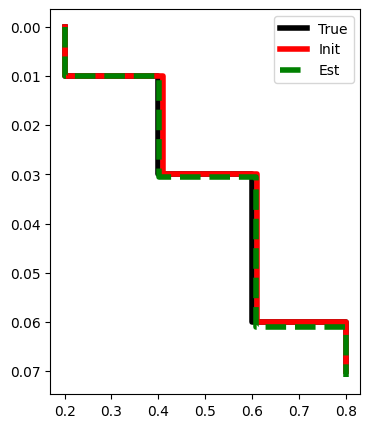

In [ ]:
thickplt = np.insert(thick, 0, 0)
vsplt = np.insert(vs, -1, vs[-1])
thick0plt = np.insert(thick0, 0, 0)
vs0plt = np.insert(vs0, -1, vs0[-1])
thickestplt = np.insert(thickest, 0, 0)
vsestplt = np.insert(vsest, -1, vsest[-1])

plt.figure(figsize=(4, 5))
plt.step(vsplt, np.cumsum(thickplt), 'k', lw=4, label='True')
plt.step(vs0plt, np.cumsum(thick0plt), 'r', lw=4, label='Init')
plt.step(vsestplt, np.cumsum(thickestplt), '--g', lw=4, label='Est')
plt.gca().invert_yaxis()
plt.legend()